<h3>Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import BaggingClassifier

<h3>Data Loading

In [2]:
#reading everything into a pandas dataframe
test_labels = pd.read_csv("labels.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
validate = pd.read_csv("validate.csv")

<h3>Feature Engineering

In [3]:
#feature engineering for totalItems
train['totalItems'] = train['totalScanTimeInSeconds'] * train['scannedLineItemsPerSecond']
test['totalItems'] = test['totalScanTimeInSeconds'] * test['scannedLineItemsPerSecond']
validate['totalItems'] = validate['totalScanTimeInSeconds'] * validate['scannedLineItemsPerSecond']

<h3>Decision Tree on Selected Features

In [4]:
selected_features = ['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids', 'scansWithoutRegistration', 'totalItems']

feature_cols = [col for col in selected_features]
target_col = ['fraud']

X_train_selected_features = train[feature_cols].copy()
X_validate_selected_features = validate[feature_cols].copy()
X_test_selected_features  = test[feature_cols].copy()

y_train = train[target_col].copy()
y_validate = validate[target_col].copy()
y_test  = test[target_col].copy()

In [5]:
#just fitting on the train set without any hyperparameter tuning
base_tree = DecisionTreeClassifier(random_state=0)
base_tree.fit(X_train_selected_features, y_train)

base_pred_train = base_tree.predict(X_train_selected_features)
base_pred_val = base_tree.predict(X_validate_selected_features)
base_pred_test = base_tree.predict(X_test_selected_features)

In [6]:
print("Train Data")
print('Accuracy score: {:0.4f}'.format(accuracy_score(y_train, base_pred_train)))
print('F1 score: {:0.4f}'.format(f1_score(y_train, base_pred_train)))
print('Precision score: {:0.4f}'.format(precision_score(y_train, base_pred_train)))
print('Recall score: {:0.4f}'.format(recall_score(y_train, base_pred_train)))
print("_________________________________________________________")

print("Validate Data")
print('Accuracy score: {:0.4f}'.format(accuracy_score(y_validate, base_pred_val)))
print('F1 score: {:0.4f}'.format(f1_score(y_validate, base_pred_val)))
print('Precision score: {:0.4f}'.format(precision_score(y_validate, base_pred_val)))
print('Recall score: {:0.4f}'.format(recall_score(y_validate, base_pred_val)))
print("_________________________________________________________")


Train Data
Accuracy score: 1.0000
F1 score: 1.0000
Precision score: 1.0000
Recall score: 1.0000
_________________________________________________________
Validate Data
Accuracy score: 0.9974
F1 score: 0.9728
Precision score: 0.9744
Recall score: 0.9712
_________________________________________________________


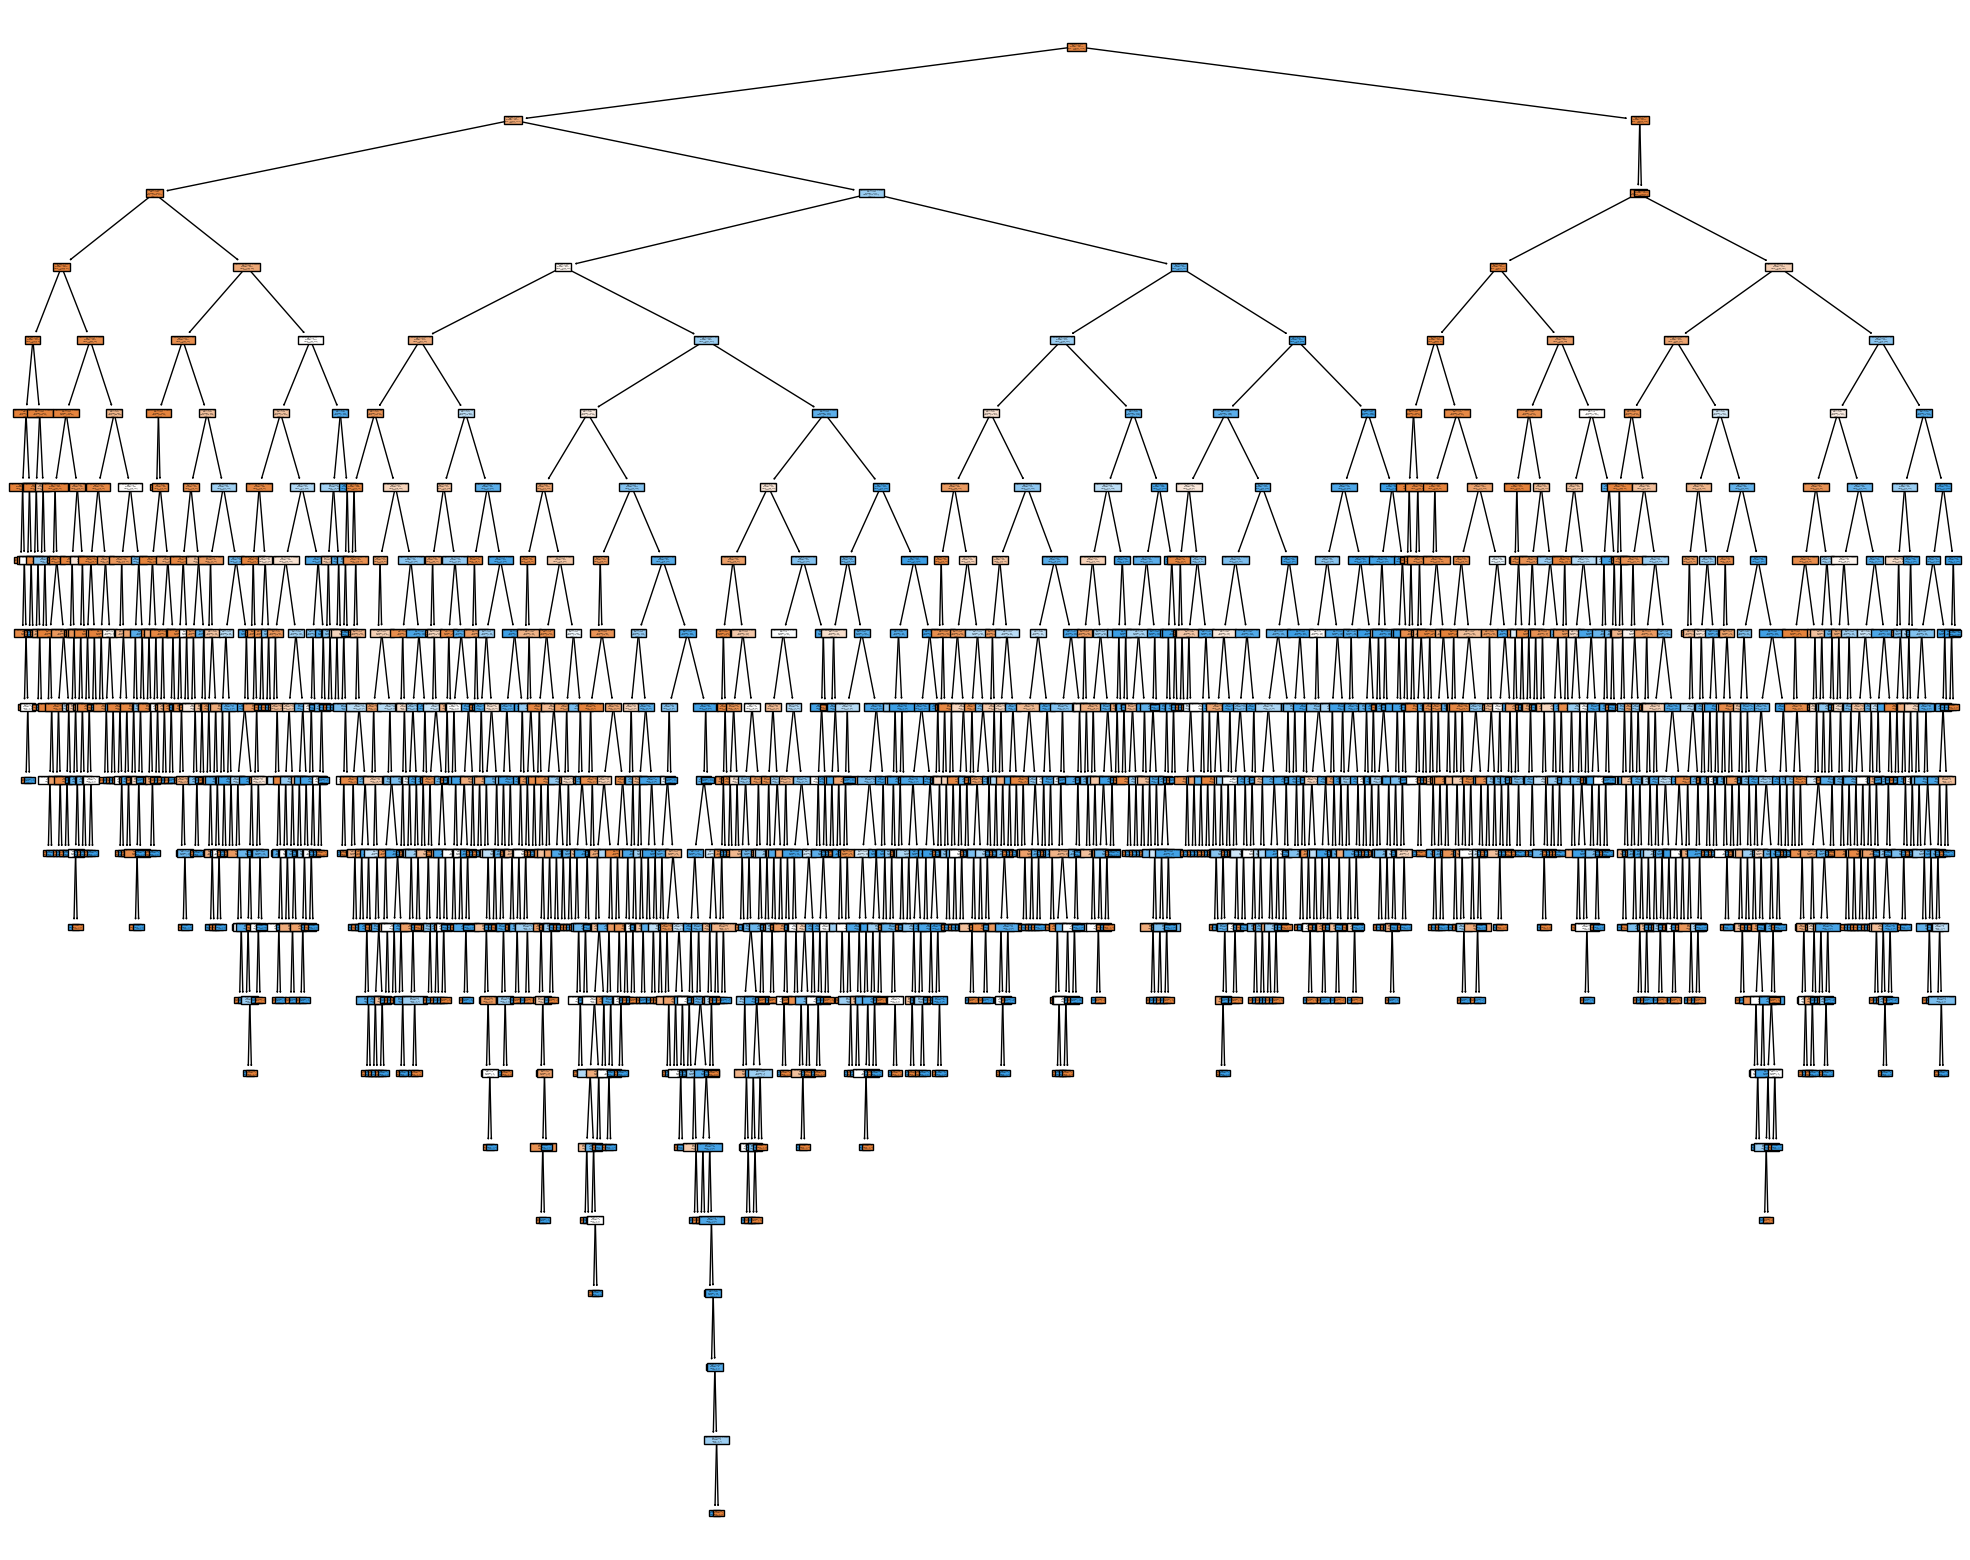

In [10]:
#visualizing the base decision tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(base_tree, feature_names=list(X_train_selected_features.columns),  class_names=['0', '1'], filled=True)

In [11]:
base_tree_text = tree.export_text(base_tree)
print(base_tree_text)

|--- feature_0 <= 1.50
|   |--- feature_5 <= 21.50
|   |   |--- feature_5 <= 19.50
|   |   |   |--- feature_5 <= 17.50
|   |   |   |   |--- feature_5 <= 16.50
|   |   |   |   |   |--- feature_1 <= 1830.50
|   |   |   |   |   |   |--- feature_1 <= 1813.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_1 >  1813.50
|   |   |   |   |   |   |   |--- feature_5 <= 15.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_5 >  15.50
|   |   |   |   |   |   |   |   |--- feature_4 <= 9.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_4 >  9.50
|   |   |   |   |   |   |   |   |   |--- feature_2 <= 48.90
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- feature_2 >  48.90
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_1 >  1830.50
|   |   |   |   |   |   |--- feature_5 <= 15.50
|   |   |   |   |   |

<h3> Hyperparameter Tuning

<h4> Random Search

In [21]:
param_dist = {
    'max_depth': np.arange(2, 11),
    'min_samples_split': np.arange(2, 31),
    'min_samples_leaf': np.arange(2, 31),
    'max_features': np.arange(1, 7),
    'splitter': ['best', 'random'],
    'criterion': ['gini', 'entropy'],
}

randomized_tree = RandomizedSearchCV(base_tree, param_distributions=param_dist, n_iter=75, cv=10, scoring="f1", random_state=0, n_jobs=-1)
randomized_tree.fit(X_train_selected_features, y_train)
best_randomized_tree = randomized_tree.best_estimator_

In [22]:
print("Getting the features for the best randomized tree")
print("best max_depth: " + str(best_randomized_tree.max_depth))
print("best min_samples_split: " + str(best_randomized_tree.min_samples_split))
print("best min_samples_leaf: " + str(best_randomized_tree.min_samples_leaf))
print("best max_features: " + str(best_randomized_tree.max_features))
print("best splitter: " + str(best_randomized_tree.splitter))
print("best criterion: " + str(best_randomized_tree.criterion))

Getting the features for the best randomized tree
best max_depth: 10
best min_samples_split: 12
best min_samples_leaf: 21
best max_features: 4
best splitter: best
best criterion: gini


In [23]:
feature_importances = best_randomized_tree.feature_importances_
top_feature_indices = np.argsort(feature_importances)[-4:]
top_feature_names = train.columns[top_feature_indices]

print(top_feature_names)

Index(['lineItemVoids', 'totalScanTimeInSeconds', 'trustLevel',
       'quantityModifications'],
      dtype='object')


In [26]:
best_randomized_tree = randomized_tree.best_estimator_

brt_pred_train = best_randomized_tree.predict(X_train_selected_features)
brt_pred_val = best_randomized_tree.predict(X_validate_selected_features)
brt_pred_test = best_randomized_tree.predict(X_test_selected_features)

In [27]:
print("Train Data")
print('Accuracy score: {:0.4f}'.format(accuracy_score(y_train, brt_pred_train)))
print('F1 score: {:0.4f}'.format(f1_score(y_train, brt_pred_train)))
print('Precision score: {:0.4f}'.format(precision_score(y_train, brt_pred_train)))
print('Recall score: {:0.4f}'.format(recall_score(y_train, brt_pred_train)))
print("_________________________________________________________")

print("Validate Data")
print('Accuracy score: {:0.4f}'.format(accuracy_score(y_validate, brt_pred_val)))
print('F1 score: {:0.4f}'.format(f1_score(y_validate, brt_pred_val)))
print('Precision score: {:0.4f}'.format(precision_score(y_validate, brt_pred_val)))
print('Recall score: {:0.4f}'.format(recall_score(y_validate, brt_pred_val)))
print("_________________________________________________________")

print("Test Data")
print('Accuracy score: {:0.4f}'.format(accuracy_score(y_test, brt_pred_test)))
print('F1 score: {:0.4f}'.format(f1_score(y_test, brt_pred_test)))
print('Precision score: {:0.4f}'.format(precision_score(y_test, brt_pred_test)))
print('Recall score: {:0.4f}'.format(recall_score(y_test, brt_pred_test)))
print("_________________________________________________________")

Train Data
Accuracy score: 0.9945
F1 score: 0.9427
Precision score: 0.9396
Recall score: 0.9458
_________________________________________________________
Validate Data
Accuracy score: 0.9936
F1 score: 0.9348
Precision score: 0.9281
Recall score: 0.9415
_________________________________________________________
Test Data
Accuracy score: 0.9936
F1 score: 0.9303
Precision score: 0.9258
Recall score: 0.9349
_________________________________________________________


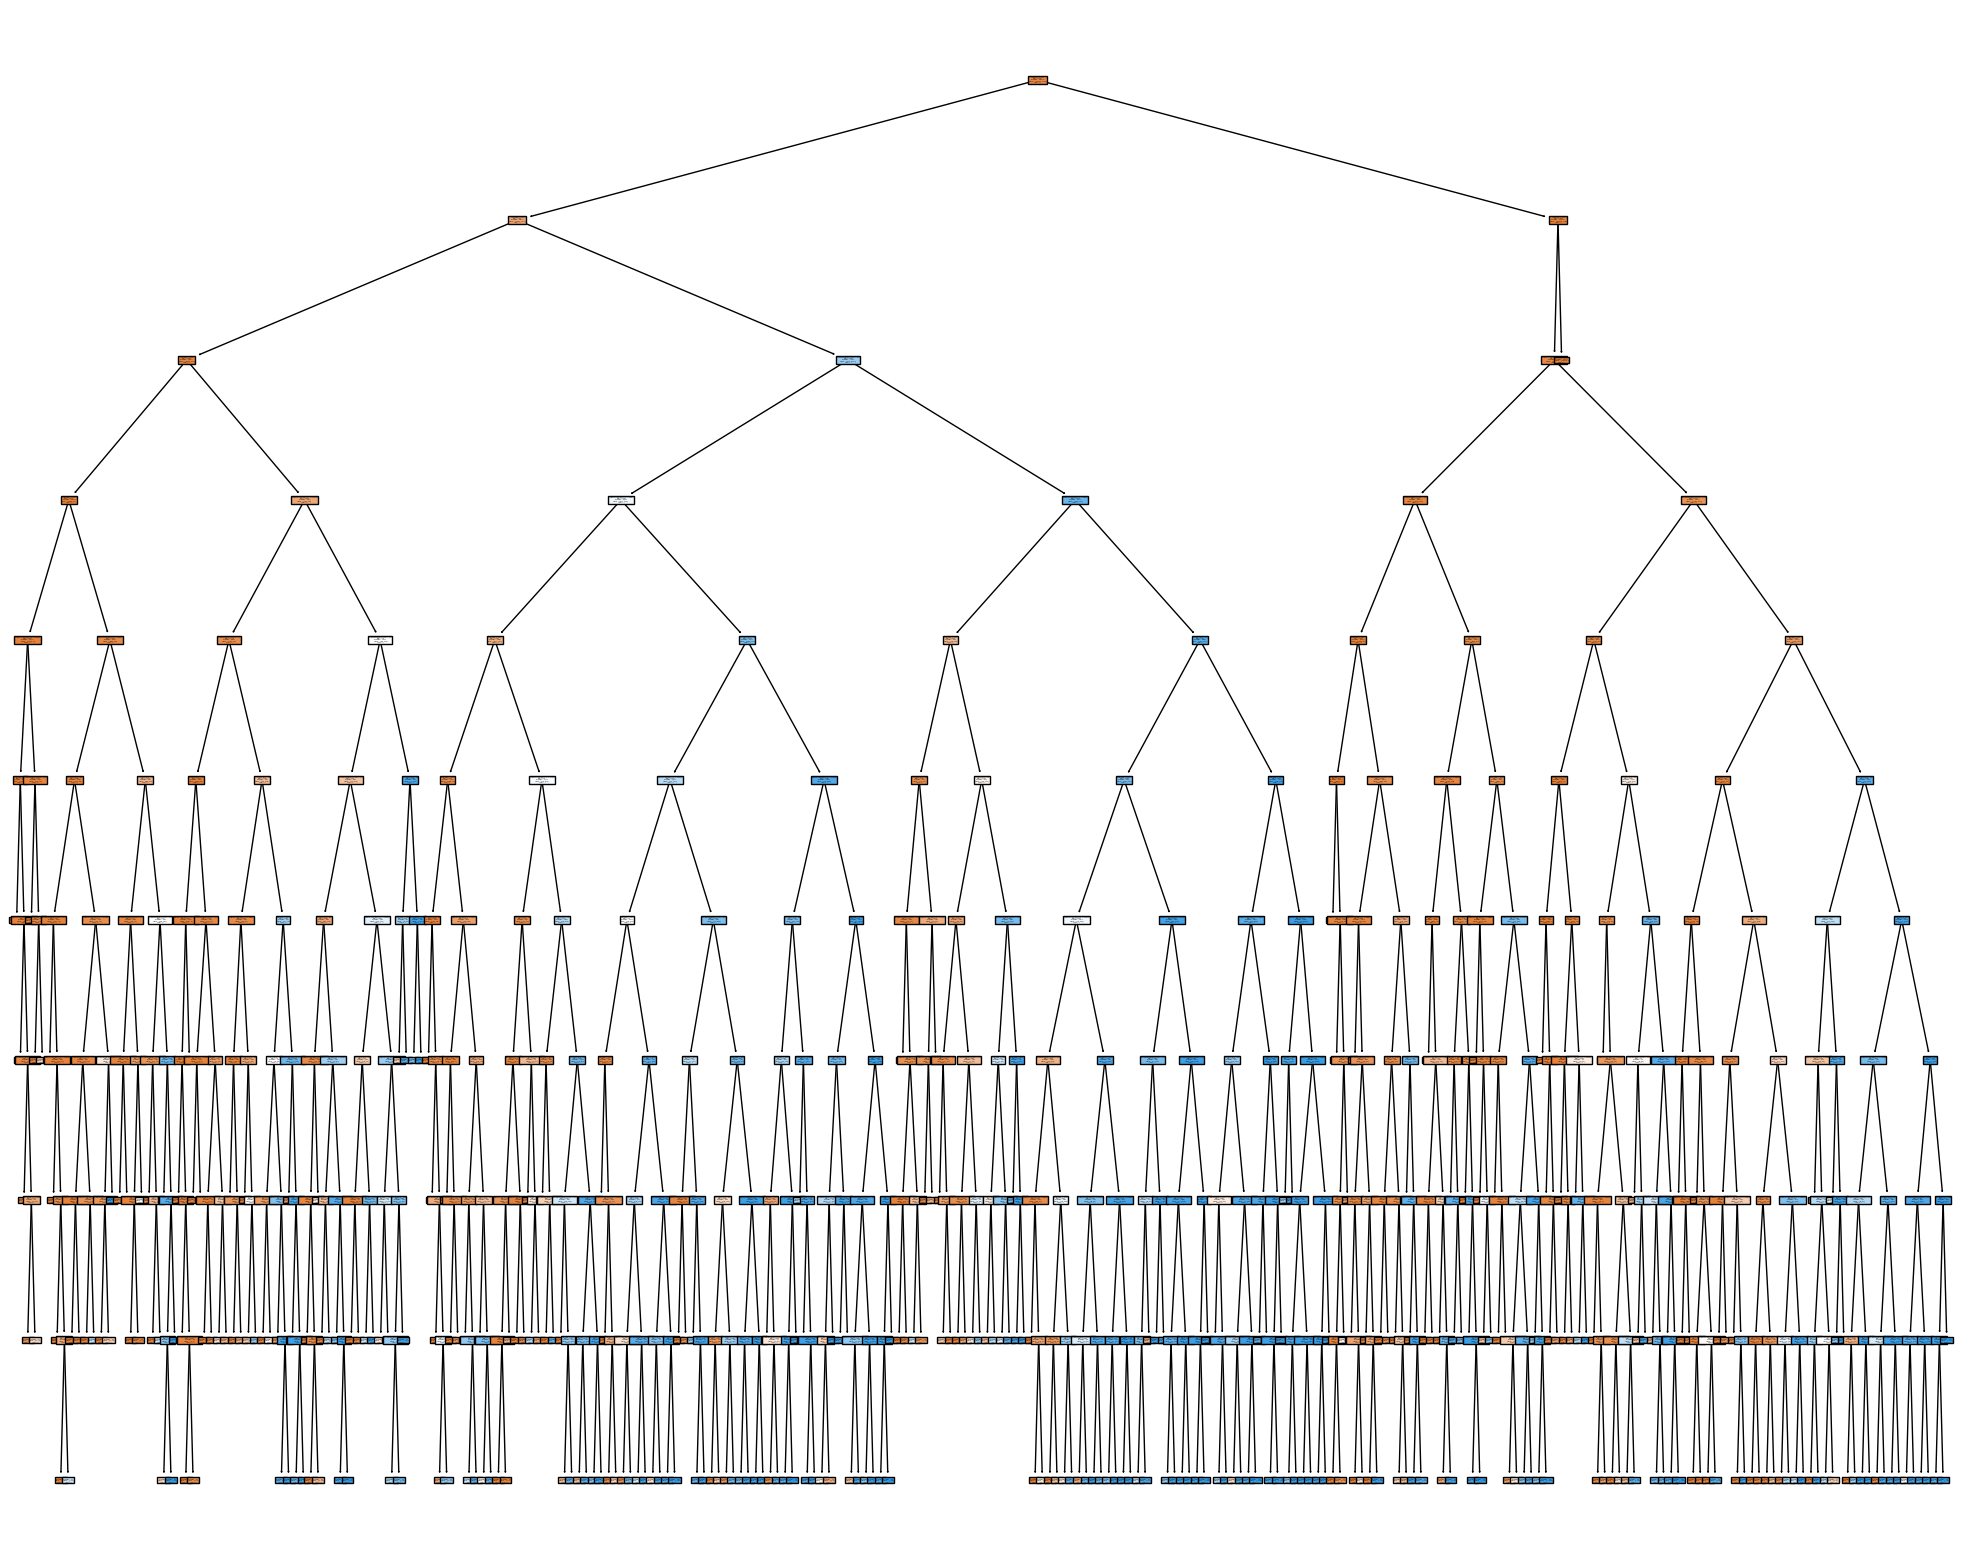

In [28]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_randomized_tree, feature_names=list(X_train_selected_features.columns),  class_names=['0', '1'], filled=True)

In [29]:
best_randomized_tree_text = tree.export_text(best_randomized_tree)
print(best_randomized_tree_text)

|--- feature_0 <= 1.50
|   |--- feature_5 <= 21.50
|   |   |--- feature_5 <= 19.50
|   |   |   |--- feature_5 <= 17.50
|   |   |   |   |--- feature_1 <= 1801.50
|   |   |   |   |   |--- feature_5 <= 16.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_5 >  16.50
|   |   |   |   |   |   |--- feature_1 <= 1514.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_1 >  1514.50
|   |   |   |   |   |   |   |--- feature_4 <= 7.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_4 >  7.50
|   |   |   |   |   |   |   |   |--- feature_2 <= 55.75
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_2 >  55.75
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_1 >  1801.50
|   |   |   |   |   |--- feature_4 <= 4.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_4 >  4.50
|   |   |   |   |   |   |--- feature_5 <= 15.

<h3> Bagging Decision Tree

In [30]:
bag_tree = BaggingClassifier(DecisionTreeClassifier(), bootstrap=True, random_state=0)
bag_tree.fit(X_train_selected_features, y_train)

bag_pred_train = bag_tree.predict(X_train_selected_features)
bag_pred_val = bag_tree.predict(X_validate_selected_features)
bag_pred_test = bag_tree.predict(X_test_selected_features)

c:\Users\kaavya\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
print("Train Data")
print('Accuracy score: {:0.4f}'.format(accuracy_score(y_train, bag_pred_train)))
print('F1 score: {:0.4f}'.format(f1_score(y_train, bag_pred_train)))
print('Precision score: {:0.4f}'.format(precision_score(y_train, bag_pred_train)))
print('Recall score: {:0.4f}'.format(recall_score(y_train, bag_pred_train)))
print("_________________________________________________________")

print("Validate Data")
print('Accuracy score: {:0.4f}'.format(accuracy_score(y_validate, bag_pred_val)))
print('F1 score: {:0.4f}'.format(f1_score(y_validate, bag_pred_val)))
print('Precision score: {:0.4f}'.format(precision_score(y_validate, bag_pred_val)))
print('Recall score: {:0.4f}'.format(recall_score(y_validate, bag_pred_val)))
print("_________________________________________________________")

print("Test Data")
print('Accuracy score: {:0.4f}'.format(accuracy_score(y_test, bag_pred_test)))
print('F1 score: {:0.4f}'.format(f1_score(y_test, bag_pred_test)))
print('Precision score: {:0.4f}'.format(precision_score(y_test, bag_pred_test)))
print('Recall score: {:0.4f}'.format(recall_score(y_test, bag_pred_test)))
print("_________________________________________________________")

Train Data
Accuracy score: 0.9999
F1 score: 0.9987
Precision score: 0.9990
Recall score: 0.9984
_________________________________________________________
Validate Data
Accuracy score: 0.9978
F1 score: 0.9770
Precision score: 0.9762
Recall score: 0.9778
_________________________________________________________
Test Data
Accuracy score: 0.9977
F1 score: 0.9750
Precision score: 0.9759
Recall score: 0.9741
_________________________________________________________
